In [2]:
%env DDE_BACKEND=tensorflow.compat.v1
# %env DDE_BACKEND = tensorflow

env: DDE_BACKEND=tensorflow.compat.v1


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term
Compiling model...
Building feed-forward neural network...
'build' took 0.058823 s


'compile' took 0.874763 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [7.38e-01, 3.54e-03, 3.58e+00]    [4.69e-01, 3.54e-03, 3.58e+00]    []  
1000      [2.09e-02, 3.54e-02, 1.26e-01]    [3.02e-02, 3.54e-02, 1.26e-01]    []  
2000      [5.06e-03, 1.87e-02, 9.50e-02]    [8.14e-03, 1.87e-02, 9.50e-02]    []  
3000      [4.83e-03, 6.77e-03, 5.57e-02]    [5.01e-03, 6.77e-03, 5.57e-02]    []  
4000      [1.97e-03, 1.73e-03, 2.99e-02]    [2.74e-03, 1.73e-03, 2.99e-02]    []  
5000      [1.17e-03, 5.88e-04, 1.80e-02]    [1.96e-03, 5.88e-04, 1.80e-02]    []  
6000      [1.09e-03, 3.37e-04, 1.56e-02]    [1.98e-03, 3.37e-04, 1.56e-02]    []  
7000      [7.10e-04, 3.06e-04, 1.47e-02]    [1.22e-03, 3.06e-04, 1.47e-02]    []  
8000      [5.23e-04, 2.64e-04

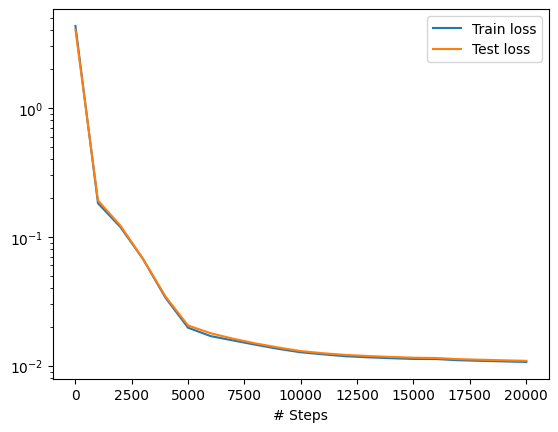

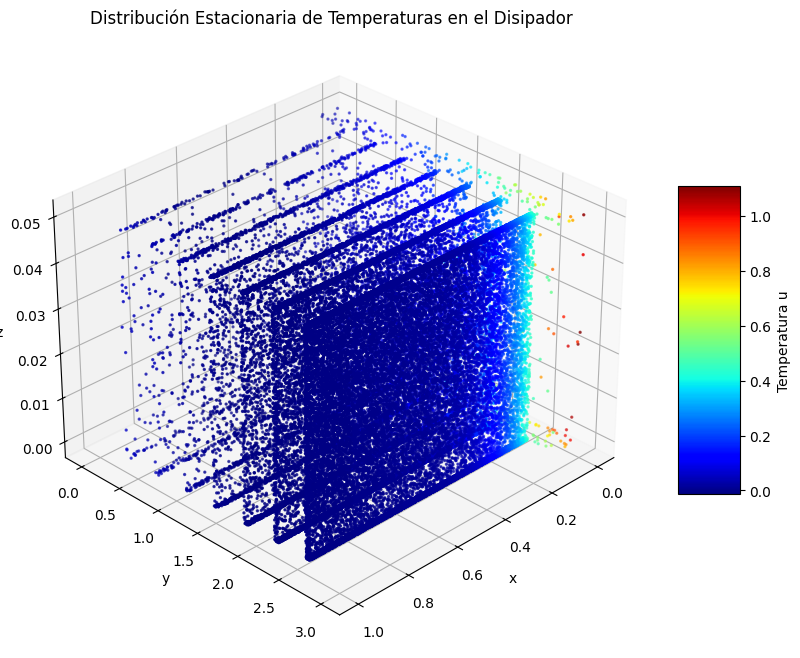

In [ ]:
import deepxde as dde
from deepxde.geometry import Cuboid, CSGUnion  # O Box si Cuboid no existe
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from deepxde.backend import tf

# Parámetros geométricos
base_width = 0.1
base_height = 3.0
base_depth = 0.05
fin_length = 0.9
fin_thickness = 0.05
fin_depth = base_depth
num_fins = 7
fin_spacing = base_height / (num_fins + 1)

# Crear geometría 3D
base = Cuboid([0.0, 0.0, 0.0], [base_width, base_height, base_depth])
geom = base
for i in range(num_fins):
    y_pos = fin_spacing * (i + 1) - fin_thickness / 2
    fin = Cuboid(
        [base_width, y_pos, 0.0],
        [base_width + fin_length, y_pos + fin_thickness, fin_depth]
    )
    geom = CSGUnion(geom, fin)

# Parámetros físicos
a = 0.4  # Difusión
beta = 0.4  # Convección

# PDE estacionaria: a * ∇²u - beta * u = 0
def pde(x, u):
    du_xx = dde.grad.hessian(u, x, i=0, j=0)
    du_yy = dde.grad.hessian(u, x, i=1, j=1)
    du_zz = dde.grad.hessian(u, x, i=2, j=2)
    laplacian = du_xx + du_yy + du_zz
    return a * laplacian - beta * u  # Residual

# BC Dirichlet: Base caliente en x=0
def boundary_base(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0.0)

bc_base = dde.DirichletBC(geom, lambda x: 1.0, boundary_base)  # u=1

# BC Robin corregido: Convección en aletas
h_over_k = 1.0  # Coeficiente convectivo
def boundary_fins(x, on_boundary):
    return on_boundary and (x[0] >= base_width)  # Caras expuestas en aletas

bc_convection = dde.RobinBC(
    geom,
    lambda x, outputs: -h_over_k * outputs,  # -α * u
    boundary_fins
)

bcs = [bc_base, bc_convection]

# Datos para PDE (estacionario, sin tiempo)
num_domain = 1000  # Interiores
num_boundary = 2000  # Fronteras
num_test = 2000
data = dde.data.PDE(
    geom,
    pde,
    bcs,
    num_domain=num_domain,
    num_boundary=num_boundary,
    num_test=num_test,
    train_distribution="Hammersley"
)

# Red neuronal: Inputs 3D (x,y,z)
net = dde.nn.FNN([3] + [50] + [1], "tanh", "Glorot normal")

# Modelo y entrenamiento
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=20000)  # Adam

model.compile("L-BFGS")
losshistory, train_state = model.train()  # Refinamiento

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

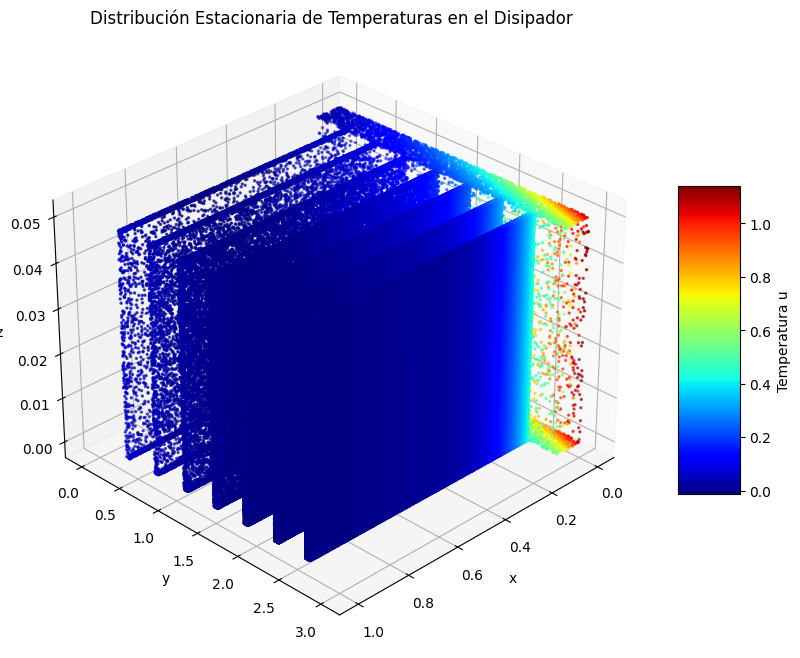

In [5]:
# Predicción: Muestrear puntos y predecir u
pred_points = geom.uniform_boundary_points(1000000)  # Interiores
#pred_points = geom.random_points(500000)  # Interiores
u_pred = model.predict(pred_points)

# Visualización 3D de temperaturas
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pred_points[:, 0], pred_points[:, 1], pred_points[:, 2], c=u_pred.flatten(), cmap='jet', s=2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Distribución Estacionaria de Temperaturas en el Disipador')
#ax.view_init(azim=5, elev=30, roll=90)
fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='Temperatura u')
ax.view_init(azim=45, elev=30)
plt.show()

In [51]:
from modulePINN import Geometry, IC_BC, loadData, PINN, Ploter, Makegrid

In [52]:
params_disipador = [0, 1, 0.1, 3.0, 0.05, 0.9, 0.05, 7]
disipador = Geometry("disipador")
geom_disipador, timedomain_disipador, geomtime_disipador = disipador.geometry_domain(params_disipador)

In [53]:
def boundary_base(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0.0)

def boundary_fins(x, on_boundary):
    return on_boundary and (x[0] >= 0.1)  # Caras expuestas en aletas

In [54]:
icbc = IC_BC(geomtime_disipador)
ic_disipador, bc_disipador = icbc.problem_conditions([0.0, 1.0, 0.1], f = lambda x, on_boundary: boundary_base(x, on_boundary))

In [55]:
# PDE transitoria: ∂u/∂t = a * ∇²u - beta * u
def pde(x, u):
    a = 0.4  # Difusión
    beta = 0.4  # Convección
    
    du_t = dde.grad.jacobian(u, x, i=0, j=3)  # ∂u/∂t (x[:,3] es t)
    du_xx = dde.grad.hessian(u, x, i=0, j=0)
    du_yy = dde.grad.hessian(u, x, i=1, j=1)
    du_zz = dde.grad.hessian(u, x, i=2, j=2)
    laplacian = du_xx + du_yy + du_zz
    return du_t - a * laplacian + beta * u  # Residual ajustado

In [56]:
data_disipador = loadData(pde, geomtime_disipador, ic_disipador, bc_disipador).get_data(2050, 1500, 200, 250)

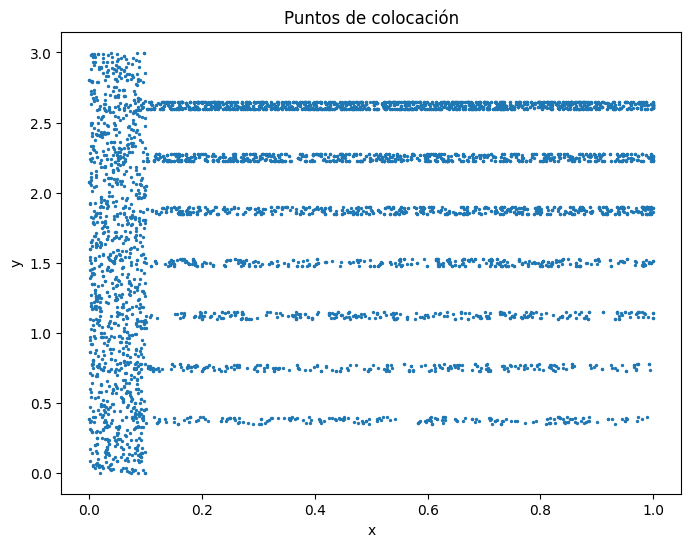

In [57]:
plots = Ploter((8,6)) # Construimos el objeto graficador para la barra
plots.collocation(data_disipador, var="y") # Graficamos los puntos de colocación (train)

In [58]:
pinn_placa = PINN(n_input=4, n_hidden=30, n_output=1, activation="tanh", mmm = "Glorot normal")
model1, losshistory1, train_state1 = pinn_placa.train_model(data_disipador, steps=2000)

Compiling model...
Building feed-forward neural network...
'build' took 0.079604 s



TypeError: 'NoneType' object is not subscriptable

In [40]:
# Red neuronal: Inputs 4D (x,y,z,t)
net = dde.nn.FNN([4] + [50] * 4 + [1], "tanh", "Glorot normal")

# Modelo y entrenamiento
model = dde.Model(data_disipador, net)
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=10000)  # Adam

model.compile("L-BFGS")
losshistory, train_state = model.train()  # Refinamiento

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
Building feed-forward neural network...
'build' took 0.118318 s



TypeError: 'NoneType' object is not subscriptable